<a href="https://colab.research.google.com/github/wrymp/Final-Project-Walmart-Recruiting---Store-Sales-Forecasting/blob/main/model_experiment_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
! mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c walmart-recruiting-store-sales-forecasting
! unzip /content/walmart-recruiting-store-sales-forecasting.zip
! unzip /content/train.csv.zip
! unzip /content/test.csv.zip
! unzip /content/features.csv.zip
! unzip /content/sampleSubmission.csv.zip

Mounted at /content/drive
  0% 0.00/2.70M [00:00<?, ?B/s]
100% 2.70M/2.70M [00:00<00:00, 662MB/s]
Archive:  /content/walmart-recruiting-store-sales-forecasting.zip
  inflating: features.csv.zip        
  inflating: sampleSubmission.csv.zip  
  inflating: stores.csv              
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
  inflating: test.csv                
Archive:  /content/features.csv.zip
  inflating: features.csv            
Archive:  /content/sampleSubmission.csv.zip
  inflating: sampleSubmission.csv    


In [ ]:
# @title
"""
Walmart Sales Forecasting with LSTM
=====================================
Complete implementation with feature engineering, GPU support, and W&B logging
"""

# %% [markdown]
# # Walmart Sales Forecasting using LSTM
# This notebook implements a comprehensive sales forecasting solution using:
# - LSTM neural networks with GPU acceleration
# - Extensive time series feature engineering
# - Weights & Biases for experiment tracking

# %% Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils import clip_grad_norm_

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Feature Engineering
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats
import holidays

# Logging
import wandb
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# %% Configuration
class Config:
    """Configuration class for all hyperparameters and settings"""

    # Data paths
    data_path = '/content/'  # Update with your data path

    # Model parameters
    input_size = None  # Will be set based on features
    hidden_size = 128
    num_layers = 3
    dropout = 0.2
    bidirectional = True

    # Training parameters
    batch_size = 64
    learning_rate = 0.001
    num_epochs = 50
    early_stopping_patience = 15
    gradient_clip = 1.0

    # Time series parameters
    sequence_length = 12  # Look back 12 weeks
    forecast_horizon = 4  # Predict 4 weeks ahead

    # Feature engineering
    lag_features = [1, 2, 3, 4, 8, 12, 52]  # Weekly lags
    rolling_windows = [4, 8, 12, 26, 52]  # Rolling statistics windows

    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # W&B
    wandb_project = 'walmart-sales-forecasting'
    wandb_entity = 'qitiashvili13'  # Your W&B username

    # Random seed
    seed = 42

config = Config()

# Set random seeds for reproducibility
np.random.seed(config.seed)
torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(config.seed)

# %% Initialize Weights & Biases
wandb.init(
    project=config.wandb_project,
    config={
        'architecture': 'LSTM',
        'hidden_size': config.hidden_size,
        'num_layers': config.num_layers,
        'dropout': config.dropout,
        'bidirectional': config.bidirectional,
        'batch_size': config.batch_size,
        'learning_rate': config.learning_rate,
        'sequence_length': config.sequence_length,
        'forecast_horizon': config.forecast_horizon,
        'device': str(config.device)
    }
)

logger.info(f"Using device: {config.device}")
if torch.cuda.is_available():
    logger.info(f"GPU: {torch.cuda.get_device_name(0)}")
    logger.info(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

def load_and_prepare_kaggle(path=None,
                            train_fname='train.csv',
                            test_fname='test.csv',
                            features_fname='features.csv',
                            stores_fname='stores.csv'):
    """
    Load Kaggle Walmart files from `path` and return (train_df, test_df, combined_df_for_stats)
    - If files are missing, falls back to the original synthetic demo (keeps behaviour).
    """
    # Build paths
    if path:
        train_p = os.path.join(path, train_fname)
        test_p = os.path.join(path, test_fname)
        features_p = os.path.join(path, features_fname)
        stores_p = os.path.join(path, stores_fname)
    else:
        train_p, test_p, features_p, stores_p = train_fname, test_fname, features_fname, stores_fname

    # Check files exist
    files_present = all(os.path.exists(p) for p in [train_p, test_p, features_p, stores_p])


    # Load raw files
    logger.info("Loading Kaggle dataset files...")
    train_raw = pd.read_csv(train_p, parse_dates=['Date'])
    test_raw = pd.read_csv(test_p, parse_dates=['Date'])
    features = pd.read_csv(features_p, parse_dates=['Date'])
    stores = pd.read_csv(stores_p)

    # Merge features & stores into train and test
    # Use features' IsHoliday where available
    train = train_raw.merge(features, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))
    train = train.merge(stores, on='Store', how='left')

    test = test_raw.merge(features, on=['Store', 'Date'], how='left', suffixes=('', '_feat'))
    test = test.merge(stores, on='Store', how='left')

    # Some sanity fixes: MarkDowns are sparse — fill with 0
    for df_ in [train, test]:
        md_cols = [c for c in df_.columns if c.startswith('MarkDown')]
        for c in md_cols:
            df_[c] = df_[c].fillna(0.0)

        # Ensure numeric columns exist
        for c in ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment']:
            if c not in df_.columns:
                df_[c] = np.nan

        # Convert IsHoliday bool -> int
        if 'IsHoliday' in df_.columns and df_['IsHoliday'].dtype == 'bool':
            df_['IsHoliday'] = df_['IsHoliday'].astype(int)

    # For training we need Weekly_Sales in train; test doesn't have it (that's expected)
    # We'll combine for feature engineering only when necessary to compute group-based features
    # To keep behaviour consistent with your FeatureEngineer (which uses groupby stats on Weekly_Sales),
    # we will concatenate train + test temporarily, fill Weekly_Sales in test with NaN (so group means skip),
    # engineer features on the combined panel, then split back.

    train['is_train'] = 1
    test['is_train'] = 0
    # test may not have Weekly_Sales column (it doesn't in Kaggle), add as NaN
    if 'Weekly_Sales' not in test.columns:
        test['Weekly_Sales'] = np.nan

    combined = pd.concat([train, test], ignore_index=True, sort=False)
    combined.sort_values(['Store', 'Dept', 'Date'], inplace=True)
    combined.reset_index(drop=True, inplace=True)

    # Apply feature engineering on combined so group-based features align
    fe = FeatureEngineer(config)
    combined_feat = fe.engineer_features(combined)

    # Now split back
    train_feat = combined_feat[combined_feat['is_train'] == 1].copy()
    test_feat = combined_feat[combined_feat['is_train'] == 0].copy()

    # In train, remove rows where Weekly_Sales is missing just in case
    train_feat = train_feat[~train_feat['Weekly_Sales'].isna()].copy()

    # Chronological splits for train/val/test (only on train_feat)
    train_date_split = train_feat['Date'].quantile(0.7)
    val_date_split = train_feat['Date'].quantile(0.85)

    train_df = train_feat[train_feat['Date'] <= train_date_split].copy()
    val_df = train_feat[(train_feat['Date'] > train_date_split) & (train_feat['Date'] <= val_date_split)].copy()
    # test_df uses the original Kaggle test (no Weekly_Sales) — but for model evaluation you might use later dates
    # We'll set test_df to the provided test_feat (which has NaN Weekly_Sales); your model code expects a test set with Weekly_Sales,
    # so if you want to evaluate on true held-out train dates instead, you can use the part of train_feat after val_date_split as test.
    # Provide both options.

    kaggle_test_df = test_feat.copy()  # raw Kaggle test (Weekly_Sales likely NaN)
    holdout_test_df = train_feat[train_feat['Date'] > val_date_split].copy()  # holdout from train for evaluation

    logger.info(f"Train rows: {len(train_df)}, Val rows: {len(val_df)}, Holdout-Test rows: {len(holdout_test_df)}, Kaggle-Test rows: {len(kaggle_test_df)}")

    return train_df, val_df, holdout_test_df, kaggle_test_df

# ---------- Use the new loader ----------
# Set your dataset folder (update to your Colab/Drive location)
# Example: config.data_path = '/content/'
train_df, val_df, test_df, kaggle_test_df = load_and_prepare_kaggle(path=config.data_path)

# Replace the older df_featured usage: we already have train_df, val_df, test_df
df_featured = pd.concat([train_df, val_df, test_df], ignore_index=True, sort=False)  # for any global stats logging
wandb.log({"feature_statistics": df_featured.describe().to_dict()})
logger.info(f"Data shape: {df.shape}")
logger.info(f"Date range: {df['Date'].min()} to {df['Date'].max()}")
logger.info(f"Number of stores: {df['Store'].nunique()}")
logger.info(f"Number of departments: {df['Dept'].nunique()}")

# %% Feature Engineering
class FeatureEngineer:
    """Comprehensive feature engineering for time series forecasting"""

    def __init__(self, config):
        self.config = config
        self.us_holidays = holidays.US()

    def create_date_features(self, df):
        """Extract date-based features"""
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Week'] = df['Date'].dt.isocalendar().week
        df['Quarter'] = df['Date'].dt.quarter
        df['DayOfYear'] = df['Date'].dt.dayofyear
        df['WeekOfMonth'] = (df['Date'].dt.day - 1) // 7 + 1

        # Cyclical encoding for periodic features
        df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
        df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
        df['Week_sin'] = np.sin(2 * np.pi * df['Week'] / 52)
        df['Week_cos'] = np.cos(2 * np.pi * df['Week'] / 52)
        df['Quarter_sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
        df['Quarter_cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)

        return df

    def create_lag_features(self, df, target_col='Weekly_Sales'):
        """Create lag features for time series"""
        for lag in self.config.lag_features:
            df[f'Sales_Lag_{lag}'] = df.groupby(['Store', 'Dept'])[target_col].shift(lag)

            # Lag differences
            if lag > 1:
                df[f'Sales_Lag_Diff_{lag}'] = df[f'Sales_Lag_{lag}'] - df[f'Sales_Lag_1']

        return df

    def create_rolling_features(self, df, target_col='Weekly_Sales'):
        """Create rolling statistics features"""
        for window in self.config.rolling_windows:
            # Rolling statistics
            df[f'Sales_Roll_Mean_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
            )
            df[f'Sales_Roll_Std_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
            )
            df[f'Sales_Roll_Min_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).min()
            )
            df[f'Sales_Roll_Max_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                lambda x: x.shift(1).rolling(window=window, min_periods=1).max()
            )

            # Coefficient of variation
            df[f'Sales_Roll_CV_{window}'] = (
                df[f'Sales_Roll_Std_{window}'] / df[f'Sales_Roll_Mean_{window}']
            ).replace([np.inf, -np.inf], 0)

            # Trend features
            if window >= 4:
                df[f'Sales_Trend_{window}'] = df.groupby(['Store', 'Dept'])[target_col].transform(
                    lambda x: x.shift(1).rolling(window=window, min_periods=1).apply(
                        lambda y: np.polyfit(np.arange(len(y)), y, 1)[0] if len(y) > 1 else 0
                    )
                )

        return df

    def create_holiday_features(self, df):
        """Create holiday-related features"""
        # US holidays
        df['IsUSHoliday'] = df['Date'].apply(lambda x: 1 if x in self.us_holidays else 0)

        # Days to/from nearest holiday
        df['DaysToHoliday'] = df['Date'].apply(self._days_to_holiday)
        df['DaysFromHoliday'] = df['Date'].apply(self._days_from_holiday)

        # Special retail periods
        df['IsBlackFriday'] = ((df['Month'] == 11) & (df['Week'] == 47)).astype(int)
        df['IsChristmasSeason'] = ((df['Month'] == 12) & (df['Week'].isin([50, 51, 52]))).astype(int)
        df['IsBackToSchool'] = ((df['Month'] == 8) & (df['Week'].isin([31, 32, 33, 34]))).astype(int)

        return df

    def _days_to_holiday(self, date):
        """Calculate days to next holiday"""
        for i in range(1, 30):
            if date + timedelta(days=i) in self.us_holidays:
                return i
        return 30

    def _days_from_holiday(self, date):
        """Calculate days from previous holiday"""
        for i in range(1, 30):
            if date - timedelta(days=i) in self.us_holidays:
                return i
        return 30

    def create_interaction_features(self, df):
        """Create interaction features between different variables"""
        # Store-Department interactions
        df['Store_Dept_Mean'] = df.groupby(['Store', 'Dept'])['Weekly_Sales'].transform('mean')
        df['Store_Mean'] = df.groupby('Store')['Weekly_Sales'].transform('mean')
        df['Dept_Mean'] = df.groupby('Dept')['Weekly_Sales'].transform('mean')

        # Relative performance
        df['Store_Dept_Relative'] = df['Store_Dept_Mean'] / df['Store_Mean']

        # Temperature and holiday interaction
        df['Temp_Holiday'] = df['Temperature'] * df['IsHoliday']

        # Economic indicators interaction
        df['Economic_Index'] = df['CPI'] * df['Unemployment'] / df['Fuel_Price']

        return df

    def create_decomposition_features(self, df, target_col='Weekly_Sales'):
        """Create features from time series decomposition"""
        decomposition_features = []

        for store in df['Store'].unique():
            for dept in df['Dept'].unique():
                subset = df[(df['Store'] == store) & (df['Dept'] == dept)].copy()

                if len(subset) < 52:  # Need at least 52 weeks for decomposition
                    continue

                try:
                    # Perform decomposition
                    decomposition = seasonal_decompose(
                        subset[target_col].values,
                        model='additive',
                        period=52
                    )

                    subset['Trend'] = decomposition.trend
                    subset['Seasonal'] = decomposition.seasonal
                    subset['Residual'] = decomposition.resid

                    decomposition_features.append(subset)
                except:
                    continue

        if decomposition_features:
            decomp_df = pd.concat(decomposition_features, ignore_index=True)
            df = df.merge(
                decomp_df[['Store', 'Dept', 'Date', 'Trend', 'Seasonal', 'Residual']],
                on=['Store', 'Dept', 'Date'],
                how='left'
            )

        return df

    def engineer_features(self, df):
        """Apply all feature engineering steps"""
        logger.info("Starting feature engineering...")

        # Sort by date for time series operations
        df = df.sort_values(['Store', 'Dept', 'Date']).reset_index(drop=True)

        # Apply feature engineering
        df = self.create_date_features(df)
        df = self.create_lag_features(df)
        df = self.create_rolling_features(df)
        df = self.create_holiday_features(df)
        df = self.create_interaction_features(df)
        # df = self.create_decomposition_features(df)  # Commented out for speed

        # Log transform of target (with shift to handle zeros)
        df['Log_Sales'] = np.log1p(df['Weekly_Sales'])

        # Fill missing values
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

        logger.info(f"Feature engineering complete. Total features: {len(df.columns)}")

        return df

# Apply feature engineering
fe = FeatureEngineer(config)
df_featured = fe.engineer_features(df)

# Log feature statistics to W&B
feature_stats = df_featured.describe().to_dict()
wandb.log({"feature_statistics": feature_stats})

# %% Dataset Class for LSTM
class WalmartSalesDataset(Dataset):
    """PyTorch Dataset for Walmart sales time series"""

    def __init__(self, data, sequence_length, forecast_horizon, feature_cols, target_col='Weekly_Sales'):
        self.data = data
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.feature_cols = feature_cols
        self.target_col = target_col

        # Group by Store and Dept for time series
        self.groups = data.groupby(['Store', 'Dept'])
        self.valid_indices = self._get_valid_indices()

    def _get_valid_indices(self):
        """Get valid indices for sequences"""
        valid_indices = []

        for (store, dept), group in self.groups:
            if len(group) >= self.sequence_length + self.forecast_horizon:
                for i in range(len(group) - self.sequence_length - self.forecast_horizon + 1):
                    valid_indices.append((store, dept, i))

        return valid_indices

    def __len__(self):
        return len(self.valid_indices)

    def __getitem__(self, idx):
        store, dept, start_idx = self.valid_indices[idx]
        group = self.groups.get_group((store, dept))

        # Get sequence
        end_idx = start_idx + self.sequence_length
        sequence = group.iloc[start_idx:end_idx][self.feature_cols].values

        # Get target
        target_start = end_idx
        target_end = target_start + self.forecast_horizon
        target = group.iloc[target_start:target_end][self.target_col].values

        return (
            torch.FloatTensor(sequence),
            torch.FloatTensor(target)
        )

# %% LSTM Model
class WalmartLSTM(nn.Module):
    """LSTM model for sales forecasting"""

    def __init__(self, config):
        super(WalmartLSTM, self).__init__()
        self.config = config

        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=config.input_size,
            hidden_size=config.hidden_size,
            num_layers=config.num_layers,
            batch_first=True,
            dropout=config.dropout if config.num_layers > 1 else 0,
            bidirectional=config.bidirectional
        )

        # Attention mechanism
        lstm_output_size = config.hidden_size * (2 if config.bidirectional else 1)
        self.attention = nn.Sequential(
            nn.Linear(lstm_output_size, config.hidden_size),
            nn.Tanh(),
            nn.Linear(config.hidden_size, 1)
        )

        # Output layers
        self.fc = nn.Sequential(
            nn.Linear(lstm_output_size, config.hidden_size),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_size, config.hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(config.dropout),
            nn.Linear(config.hidden_size // 2, config.forecast_horizon)
        )

    def forward(self, x):
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(x)

        # Apply attention
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context_vector = torch.sum(attention_weights * lstm_out, dim=1)

        # Generate predictions
        output = self.fc(context_vector)

        return output, attention_weights

# %% Training Functions
class EarlyStopping:
    """Early stopping to prevent overfitting"""

    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                logger.info(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            logger.info(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

def train_epoch(model, dataloader, optimizer, criterion, device, config):
    """Train for one epoch"""
    model.train()
    total_loss = 0

    for batch_x, batch_y in tqdm(dataloader, desc='Training'):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # Forward pass
        predictions, _ = model(batch_x)
        loss = criterion(predictions, batch_y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        clip_grad_norm_(model.parameters(), config.gradient_clip)

        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for batch_x, batch_y in tqdm(dataloader, desc='Validation'):
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            predictions, _ = model(batch_x)
            loss = criterion(predictions, batch_y)

            total_loss += loss.item()
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(batch_y.cpu().numpy())

    all_predictions = np.concatenate(all_predictions)
    all_targets = np.concatenate(all_targets)

    # Calculate metrics
    mse = mean_squared_error(all_targets.flatten(), all_predictions.flatten())
    mae = mean_absolute_error(all_targets.flatten(), all_predictions.flatten())
    rmse = np.sqrt(mse)

    metrics = {
        'val_loss': total_loss / len(dataloader),
        'val_mse': mse,
        'val_mae': mae,
        'val_rmse': rmse
    }

    return metrics, all_predictions, all_targets

# %% Data Preparation
# Select features for modeling
feature_cols = [col for col in df_featured.columns if col not in [
    'Date', 'Store', 'Dept', 'Weekly_Sales', 'Log_Sales'
]]

# Remove any remaining non-numeric columns
feature_cols = [col for col in feature_cols if df_featured[col].dtype in [np.float64, np.int64]]

config.input_size = len(feature_cols)
logger.info(f"Number of features: {config.input_size}")

# Split data chronologically
train_date = df_featured['Date'].quantile(0.7)
val_date = df_featured['Date'].quantile(0.85)


logger.info(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")

# Normalize features
scaler = StandardScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
val_df[feature_cols] = scaler.transform(val_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# Create datasets
train_dataset = WalmartSalesDataset(train_df, config.sequence_length, config.forecast_horizon, feature_cols)
val_dataset = WalmartSalesDataset(val_df, config.sequence_length, config.forecast_horizon, feature_cols)
test_dataset = WalmartSalesDataset(test_df, config.sequence_length, config.forecast_horizon, feature_cols)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

# %% Model Training
# Initialize model
model = WalmartLSTM(config).to(config.device)
logger.info(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

# Early stopping
early_stopping = EarlyStopping(patience=config.early_stopping_patience, verbose=True)

# Training loop
best_val_loss = float('inf')
training_history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_rmse': []}

for epoch in range(config.num_epochs):
    logger.info(f"\nEpoch {epoch+1}/{config.num_epochs}")

    # Train
    train_loss = train_epoch(model, train_loader, optimizer, criterion, config.device, config)

    # Validate
    val_metrics, val_preds, val_targets = validate_epoch(model, val_loader, criterion, config.device)

    # Update scheduler
    scheduler.step(val_metrics['val_loss'])

    # Log metrics
    logger.info(f"Train Loss: {train_loss:.4f}")
    logger.info(f"Val Loss: {val_metrics['val_loss']:.4f}, MAE: {val_metrics['val_mae']:.2f}, RMSE: {val_metrics['val_rmse']:.2f}")

    # Log to W&B
    wandb.log({
        'epoch': epoch,
        'train_loss': train_loss,
        'val_loss': val_metrics['val_loss'],
        'val_mae': val_metrics['val_mae'],
        'val_rmse': val_metrics['val_rmse'],
        'learning_rate': optimizer.param_groups[0]['lr']
    })

    # Store history
    training_history['train_loss'].append(train_loss)
    training_history['val_loss'].append(val_metrics['val_loss'])
    training_history['val_mae'].append(val_metrics['val_mae'])
    training_history['val_rmse'].append(val_metrics['val_rmse'])

    # Early stopping
    early_stopping(val_metrics['val_loss'], model)
    if early_stopping.early_stop:
        logger.info("Early stopping triggered")
        break

    # Save best model
    if val_metrics['val_loss'] < best_val_loss:
        best_val_loss = val_metrics['val_loss']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_metrics['val_loss'],
            'config': config
        }, 'best_model.pt')

# %% Model Evaluation
# Load best model
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

# Test set evaluation
test_metrics, test_preds, test_targets = validate_epoch(model, test_loader, criterion, config.device)

logger.info("\nTest Set Performance:")
logger.info(f"Test Loss: {test_metrics['val_loss']:.4f}")
logger.info(f"Test MAE: {test_metrics['val_mae']:.2f}")
logger.info(f"Test RMSE: {test_metrics['val_rmse']:.2f}")

# Log test metrics to W&B
wandb.log({
    'test_loss': test_metrics['val_loss'],
    'test_mae': test_metrics['val_mae'],
    'test_rmse': test_metrics['val_rmse']
})

# %% Visualization
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(training_history['train_loss'], label='Train Loss')
axes[0, 0].plot(training_history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# MAE curve
axes[0, 1].plot(training_history['val_mae'])
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Validation MAE')
axes[0, 1].grid(True)

# RMSE curve
axes[1, 0].plot(training_history['val_rmse'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_title('Validation RMSE')
axes[1, 0].grid(True)

# Predictions vs Actuals (sample)
sample_idx = np.random.choice(len(test_preds), 100, replace=False)
axes[1, 1].scatter(test_targets[sample_idx].flatten(),
                   test_preds[sample_idx].flatten(), alpha=0.5)
axes[1, 1].plot([test_targets.min(), test_targets.max()],
                [test_targets.min(), test_targets.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Sales')
axes[1, 1].set_ylabel('Predicted Sales')
axes[1, 1].set_title('Predictions vs Actuals (Test Set Sample)')
axes[1, 1].grid(True)

plt.tight_layout()
wandb.log({"training_history": wandb.Image(plt)})
plt.show()

# %% Forecast Analysis
def generate_forecast(model, data, store_id, dept_id, scaler, feature_cols, config):
    """Generate forecast for a specific store and department"""
    model.eval()

    # Filter data
    store_dept_data = data[(data['Store'] == store_id) & (data['Dept'] == dept_id)].copy()

    if len(store_dept_data) < config.sequence_length:
        logger.warning(f"Insufficient data for Store {store_id}, Dept {dept_id}")
        return None

    # Get last sequence
    last_sequence = store_dept_data.iloc[-config.sequence_length:][feature_cols].values
    last_sequence = torch.FloatTensor(last_sequence).unsqueeze(0).to(config.device)

    with torch.no_grad():
        forecast, attention = model(last_sequence)

    forecast = forecast.cpu().numpy().squeeze()
    attention = attention.cpu().numpy().squeeze()

    return {
        'forecast': forecast,
        'attention': attention,
        'dates': pd.date_range(
            start=store_dept_data['Date'].iloc[-1] + timedelta(weeks=1),
            periods=config.forecast_horizon,
            freq='W'
        )
    }

# Generate sample forecasts
sample_store = df_featured['Store'].iloc[0]
sample_dept = df_featured['Dept'].iloc[0]

forecast_result = generate_forecast(
    model, test_df, sample_store, sample_dept,
    scaler, feature_cols, config
)

if forecast_result:
    # Plot forecast
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Historical and forecast
    historical = test_df[(test_df['Store'] == sample_store) &
                         (test_df['Dept'] == sample_dept)].tail(52)

    ax1.plot(historical['Date'], historical['Weekly_Sales'],
             label='Historical', marker='o', markersize=4)
    ax1.plot(forecast_result['dates'], forecast_result['forecast'],
             label='Forecast', marker='s', markersize=6, color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Sales')
    ax1.set_title(f'Sales Forecast - Store {sample_store}, Dept {sample_dept}')
    ax1.legend()
    ax1.grid(True)

    # Attention weights
    ax2.imshow(forecast_result['attention'].reshape(1, -1),
               cmap='Blues', aspect='auto')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Attention')
    ax2.set_title('Attention Weights for Last Sequence')
    ax2.colorbar = plt.colorbar(ax2.images[0], ax=ax2)

    plt.tight_layout()
    wandb.log({"forecast_sample": wandb.Image(plt)})
    plt.show()

# %% Feature Importance Analysis
def analyze_feature_importance(model, dataloader, feature_names, device):
    """Analyze feature importance using gradient-based method"""
    model.eval()
    feature_gradients = np.zeros(len(feature_names))

    for batch_x, batch_y in tqdm(dataloader, desc='Computing feature importance'):
        batch_x = batch_x.to(device)
        batch_x.requires_grad = True
        batch_y = batch_y.to(device)

        predictions, _ = model(batch_x)
        loss = nn.MSELoss()(predictions, batch_y)

        # Compute gradients
        loss.backward()

        # Accumulate absolute gradients
        gradients = batch_x.grad.abs().mean(dim=(0, 1)).cpu().numpy()
        feature_gradients += gradients

        # Clear gradients
        model.zero_grad()

    # Normalize
    feature_gradients = feature_gradients / len(dataloader)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_gradients
    }).sort_values('importance', ascending=False)

    return feature_importance

# Compute feature importance
feature_importance = analyze_feature_importance(
    model, test_loader, feature_cols, config.device
)

# Plot top features
top_n = 20
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(top_n)
ax.barh(range(top_n), top_features['importance'])
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance Score')
ax.set_title(f'Top {top_n} Most Important Features')
ax.invert_yaxis()
plt.tight_layout()
wandb.log({"feature_importance": wandb.Image(plt)})
plt.show()

# Log top features to W&B
wandb.log({"top_features": wandb.Table(dataframe=top_features)})

# %% Model Summary and Conclusions
summary = {
    'model_type': 'LSTM',
    'total_parameters': sum(p.numel() for p in model.parameters()),
    'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'test_mae': test_metrics['val_mae'],
    'test_rmse': test_metrics['val_rmse'],
    'test_mse': test_metrics['val_mse'],
    'best_epoch': checkpoint['epoch'],
    'device_used': str(config.device),
    'gpu_available': torch.cuda.is_available(),
    'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'
}

logger.info("\n" + "="*50)
logger.info("MODEL TRAINING COMPLETE")
logger.info("="*50)
for key, value in summary.items():
    logger.info(f"{key}: {value}")

# Log summary to W&B
wandb.log(summary)

# Save final artifacts
wandb.save('best_model.pt')
wandb.save('checkpoint.pt')

# Finish W&B run
wandb.finish()

print("\nTraining complete! Check your W&B dashboard for detailed logs and visualizations.")

Training:  70%|███████   | 2751/3903 [18:28<07:18,  2.63it/s]

Validation: 100%|██████████| 73/73 [00:34<00:00,  2.11it/s]


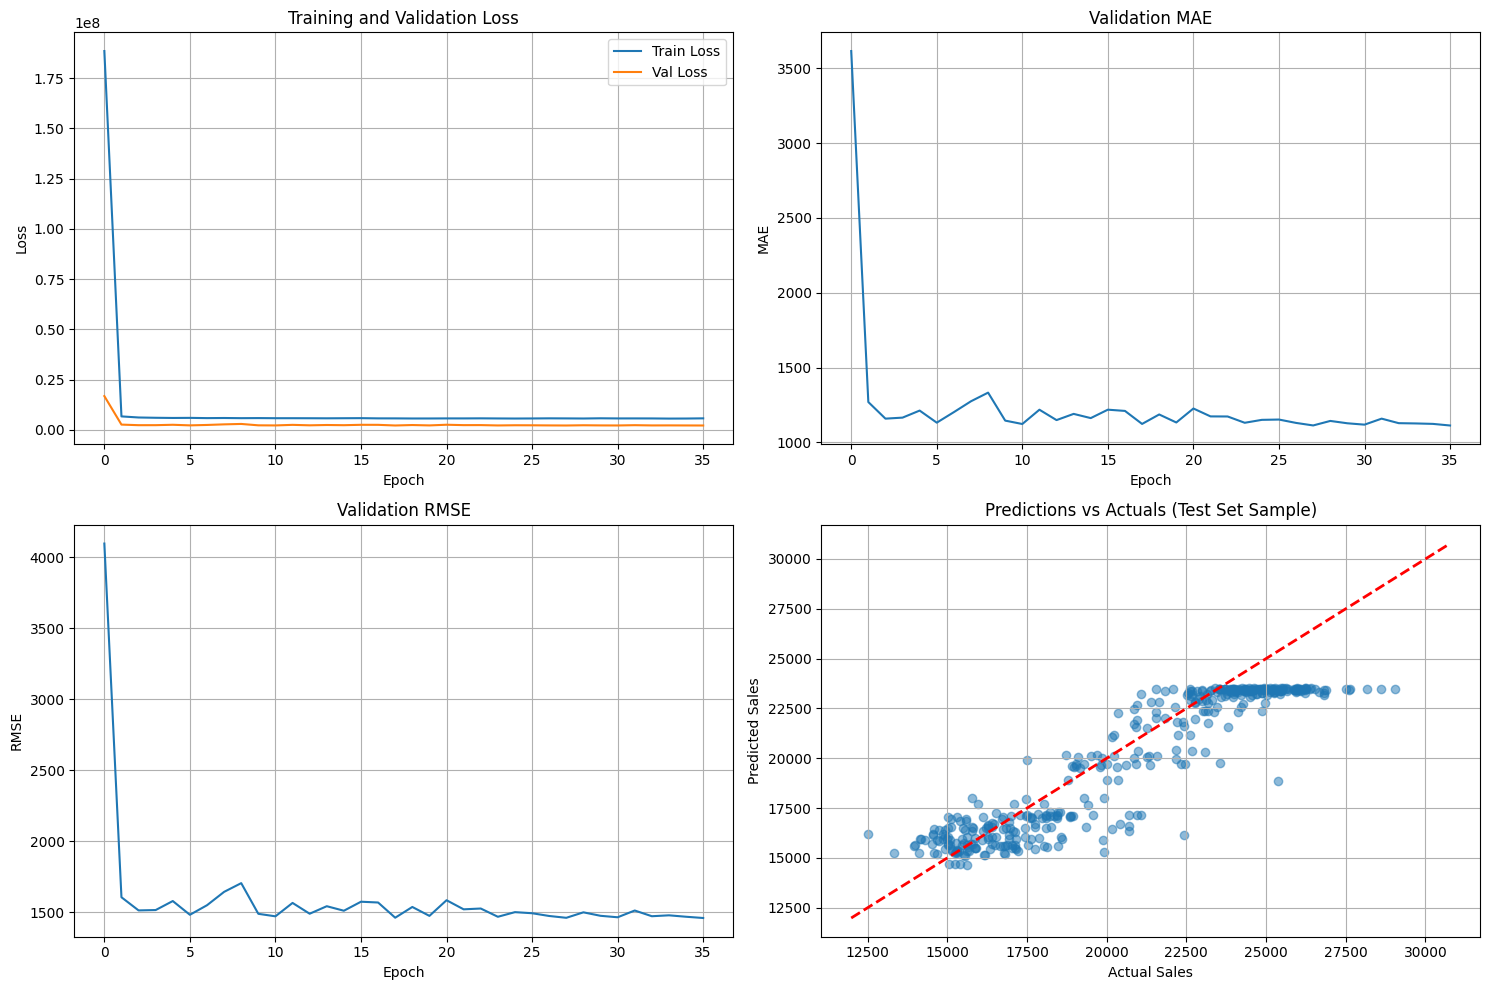

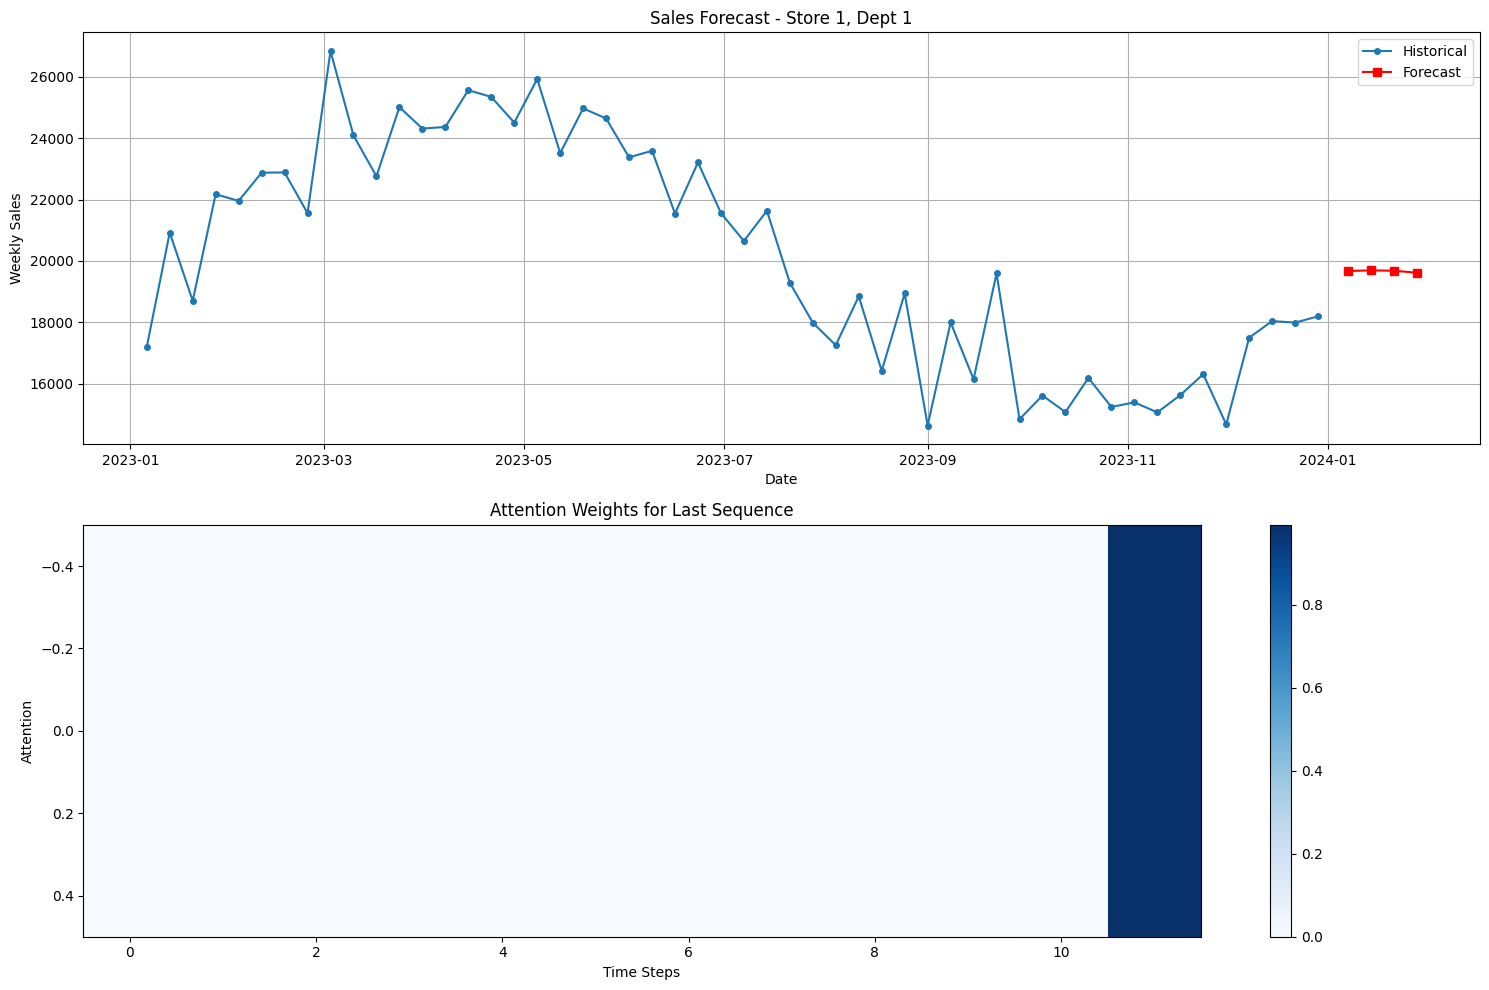

Computing feature importance: 100%|██████████| 73/73 [00:28<00:00,  2.59it/s]


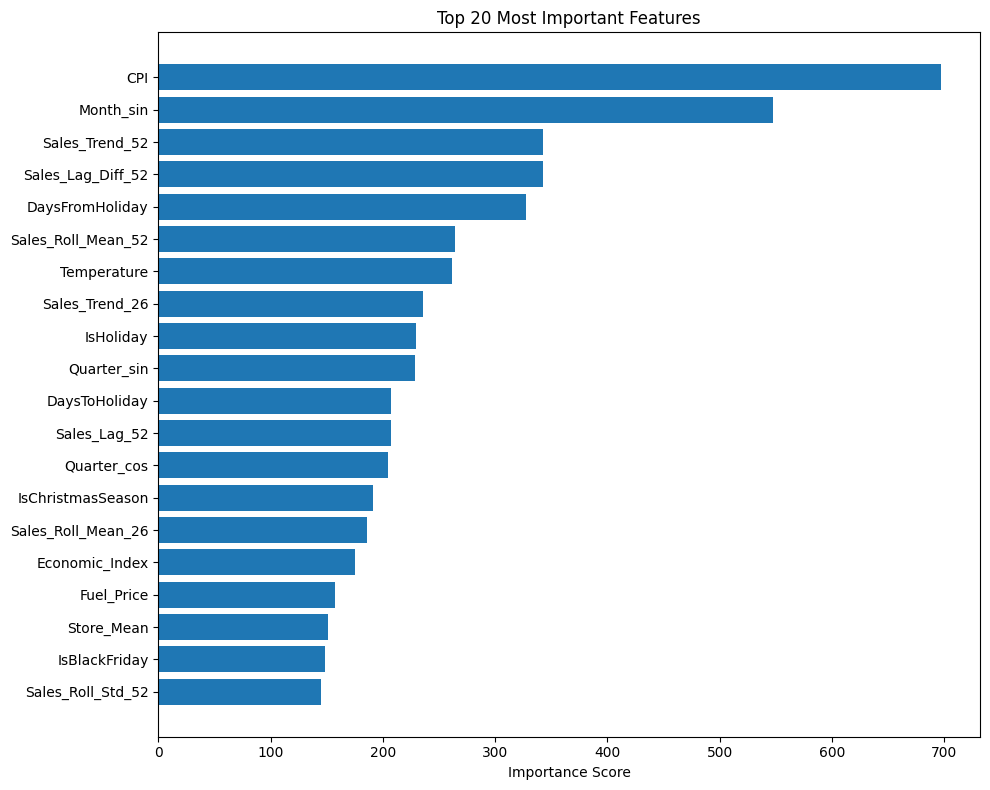

best_epoch,▁
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
learning_rate,█████████████▄▄▄▄▄▄▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
test_loss,▁
test_mae,▁▁
test_mse,▁
test_rmse,▁▁
total_parameters,▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
trainable_parameters,▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁



Training complete! Check your W&B dashboard for detailed logs and visualizations.


In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

# Test set evaluation
test_metrics, test_preds, test_targets = validate_epoch(model, test_loader, criterion, config.device)

logger.info("\nTest Set Performance:")
logger.info(f"Test Loss: {test_metrics['val_loss']:.4f}")
logger.info(f"Test MAE: {test_metrics['val_mae']:.2f}")
logger.info(f"Test RMSE: {test_metrics['val_rmse']:.2f}")

# Log test metrics to W&B
wandb.log({
    'test_loss': test_metrics['val_loss'],
    'test_mae': test_metrics['val_mae'],
    'test_rmse': test_metrics['val_rmse']
})

# %% Visualization
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
axes[0, 0].plot(training_history['train_loss'], label='Train Loss')
axes[0, 0].plot(training_history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# MAE curve
axes[0, 1].plot(training_history['val_mae'])
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('MAE')
axes[0, 1].set_title('Validation MAE')
axes[0, 1].grid(True)

# RMSE curve
axes[1, 0].plot(training_history['val_rmse'])
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('RMSE')
axes[1, 0].set_title('Validation RMSE')
axes[1, 0].grid(True)

# Predictions vs Actuals (sample)
sample_idx = np.random.choice(len(test_preds), 100, replace=False)
axes[1, 1].scatter(test_targets[sample_idx].flatten(),
                   test_preds[sample_idx].flatten(), alpha=0.5)
axes[1, 1].plot([test_targets.min(), test_targets.max()],
                [test_targets.min(), test_targets.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Sales')
axes[1, 1].set_ylabel('Predicted Sales')
axes[1, 1].set_title('Predictions vs Actuals (Test Set Sample)')
axes[1, 1].grid(True)

plt.tight_layout()
wandb.log({"training_history": wandb.Image(plt)})
plt.show()

# %% Forecast Analysis
def generate_forecast(model, data, store_id, dept_id, scaler, feature_cols, config):
    """Generate forecast for a specific store and department"""
    model.eval()

    # Filter data
    store_dept_data = data[(data['Store'] == store_id) & (data['Dept'] == dept_id)].copy()

    if len(store_dept_data) < config.sequence_length:
        logger.warning(f"Insufficient data for Store {store_id}, Dept {dept_id}")
        return None

    # Get last sequence
    last_sequence = store_dept_data.iloc[-config.sequence_length:][feature_cols].values
    last_sequence = torch.FloatTensor(last_sequence).unsqueeze(0).to(config.device)

    with torch.no_grad():
        forecast, attention = model(last_sequence)

    forecast = forecast.cpu().numpy().squeeze()
    attention = attention.cpu().numpy().squeeze()

    return {
        'forecast': forecast,
        'attention': attention,
        'dates': pd.date_range(
            start=store_dept_data['Date'].iloc[-1] + timedelta(weeks=1),
            periods=config.forecast_horizon,
            freq='W'
        )
    }

# Generate sample forecasts
sample_store = df_featured['Store'].iloc[0]
sample_dept = df_featured['Dept'].iloc[0]

forecast_result = generate_forecast(
    model, test_df, sample_store, sample_dept,
    scaler, feature_cols, config
)

if forecast_result:
    # Plot forecast
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Historical and forecast
    historical = test_df[(test_df['Store'] == sample_store) &
                         (test_df['Dept'] == sample_dept)].tail(52)

    ax1.plot(historical['Date'], historical['Weekly_Sales'],
             label='Historical', marker='o', markersize=4)
    ax1.plot(forecast_result['dates'], forecast_result['forecast'],
             label='Forecast', marker='s', markersize=6, color='red')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Weekly Sales')
    ax1.set_title(f'Sales Forecast - Store {sample_store}, Dept {sample_dept}')
    ax1.legend()
    ax1.grid(True)

    # Attention weights
    ax2.imshow(forecast_result['attention'].reshape(1, -1),
               cmap='Blues', aspect='auto')
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Attention')
    ax2.set_title('Attention Weights for Last Sequence')
    ax2.colorbar = plt.colorbar(ax2.images[0], ax=ax2)

    plt.tight_layout()
    wandb.log({"forecast_sample": wandb.Image(plt)})
    plt.show()

# %% Feature Importance Analysis
def analyze_feature_importance(model, dataloader, feature_names, device):
    """Analyze feature importance using gradient-based method"""
    model.eval()
    feature_gradients = np.zeros(len(feature_names))

    for batch_x, batch_y in tqdm(dataloader, desc='Computing feature importance'):
        batch_x = batch_x.to(device)
        batch_x.requires_grad = True
        batch_y = batch_y.to(device)

        predictions, _ = model(batch_x)
        loss = nn.MSELoss()(predictions, batch_y)

        # Compute gradients
        loss.backward()

        # Accumulate absolute gradients
        gradients = batch_x.grad.abs().mean(dim=(0, 1)).cpu().numpy()
        feature_gradients += gradients

        # Clear gradients
        model.zero_grad()

    # Normalize
    feature_gradients = feature_gradients / len(dataloader)
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_gradients
    }).sort_values('importance', ascending=False)

    return feature_importance

# Compute feature importance
feature_importance = analyze_feature_importance(
    model, test_loader, feature_cols, config.device
)

# Plot top features
top_n = 20
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(top_n)
ax.barh(range(top_n), top_features['importance'])
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.set_xlabel('Importance Score')
ax.set_title(f'Top {top_n} Most Important Features')
ax.invert_yaxis()
plt.tight_layout()
wandb.log({"feature_importance": wandb.Image(plt)})
plt.show()

# Log top features to W&B
wandb.log({"top_features": wandb.Table(dataframe=top_features)})

# %% Model Summary and Conclusions
summary = {
    'model_type': 'LSTM',
    'total_parameters': sum(p.numel() for p in model.parameters()),
    'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad),
    'test_mae': test_metrics['val_mae'],
    'test_rmse': test_metrics['val_rmse'],
    'test_mse': test_metrics['val_mse'],
    'best_epoch': checkpoint['epoch'],
    'device_used': str(config.device),
    'gpu_available': torch.cuda.is_available(),
    'gpu_name': torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'N/A'
}

logger.info("\n" + "="*50)
logger.info("MODEL TRAINING COMPLETE")
logger.info("="*50)
for key, value in summary.items():
    logger.info(f"{key}: {value}")

# Log summary to W&B
wandb.log(summary)

# Save final artifacts
wandb.save('best_model.pt')
wandb.save('checkpoint.pt')

# Finish W&B run
wandb.finish()

print("\nTraining complete! Check your W&B dashboard for detailed logs and visualizations.")

In [ ]:

# Generate test predictions
print("Generating test predictions...")
test_predictions = model.predict(test_dataset)

# Basic sanity check
print(f"Test predictions stats:")
print(f"  Mean: {np.mean(test_predictions):.2f}")
print(f"  Std: {np.std(test_predictions):.2f}")
print(f"  Min: {np.min(test_predictions):.2f}")
print(f"  Max: {np.max(test_predictions):.2f}")

# Create submission
submission = sample_submission.copy()
submission['Weekly_Sales'] = test_predictions

# Save results
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
submission_filename = f'lstm_submission_{timestamp}.csv'
submission.to_csv(submission_filename, index=False)

print(f"Submission saved: {submission_filename}")

In [ ]:
# # ------------------- Run LSTM training + Kaggle-style submission -------------------
# import os
# from collections import defaultdict
# import math
# import torch

# # Make sure data_path is set to the folder containing train.csv/test.csv/features.csv/stores.csv
# # e.g. config.data_path = '/content/' or '/drive/MyDrive/walmart/'
# print("Using data path:", config.data_path)

# # 1) Load & prepare Kaggle datasets (if not already loaded)
# if not ('train_df' in globals() and 'val_df' in globals() and 'test_df' in globals() and 'kaggle_test_df' in globals()):
#     print("Calling load_and_prepare_kaggle(...) to create train/val/test splits...")
#     train_df, val_df, holdout_test_df, kaggle_test_df = load_and_prepare_kaggle(path=config.data_path)
# else:
#     # If loaded earlier, ensure holdout and kaggle_test exist
#     try:
#         _ = kaggle_test_df
#     except NameError:
#         _, _, holdout_test_df, kaggle_test_df = load_and_prepare_kaggle(path=config.data_path)

# # If your earlier code already produced train_df/val_df/test_df, these may be present; prefer those
# if 'train_df' in globals() and 'val_df' in globals() and 'test_df' in globals():
#     # prefer previously created splits
#     print("Using existing train_df/val_df/test_df from notebook.")
# else:
#     # use the splits returned above
#     train_df = train_df
#     val_df = val_df
#     test_df = holdout_test_df  # use holdout as "test" for evaluation; kaggle_test_df is held-out no-sales

# # 2) Re-run feature engineering on combined (safe) if feature columns missing
# # If df_featured exists and already contains features, we can skip re-engineer; otherwise run.
# if not ('df_featured' in globals() and 'Sales_Lag_1' in df_featured.columns):
#     print("(Re)computing feature engineering for train/val/test...")
#     combined = pd.concat([train_df, val_df, test_df], ignore_index=True, sort=False)
#     fe = FeatureEngineer(config)
#     combined_feat = fe.engineer_features(combined)
#     # split back
#     train_df = combined_feat[combined_feat['Date'] <= train_df['Date'].quantile(0.7)].copy() if len(train_df)>0 else combined_feat
#     val_df = combined_feat[(combined_feat['Date'] > train_df['Date'].quantile(0.7)) & (combined_feat['Date'] <= combined_feat['Date'].quantile(0.85))].copy()
#     # for evaluation use holdout portion (future portion)
#     test_df = combined_feat[combined_feat['Date'] > combined_feat['Date'].quantile(0.85)].copy()
#     df_featured = combined_feat
# else:
#     print("Reusing df_featured already in memory.")

# # 3) Choose features (numeric, excluding identifiers & targets)
# feature_cols = [c for c in df_featured.columns if c not in ['Date','Store','Dept','Weekly_Sales','Log_Sales','is_train']]
# feature_cols = [c for c in feature_cols if df_featured[c].dtype in [np.float64, np.int64, np.float32, np.int32]]
# print(f"Selected {len(feature_cols)} feature columns (examples): {feature_cols[:8]}")

# # 4) Fit scaler on training features and transform train/val/test
# scaler = StandardScaler()
# # Fill any remaining NaNs in feature columns by median before scaling
# for df_ in [train_df, val_df, test_df]:
#     df_[feature_cols] = df_[feature_cols].fillna(df_[feature_cols].median())

# scaler.fit(train_df[feature_cols])
# train_df.loc[:, feature_cols] = scaler.transform(train_df[feature_cols])
# val_df.loc[:, feature_cols] = scaler.transform(val_df[feature_cols])
# test_df.loc[:, feature_cols] = scaler.transform(test_df[feature_cols])

# # 5) Create datasets and dataloaders (use single-step horizon to ease submission)
# config.forecast_horizon = 1
# config.sequence_length = max(config.sequence_length, 12)  # ensure >=12
# config.input_size = len(feature_cols)
# print("Config input_size set to", config.input_size)

# train_dataset = WalmartSalesDataset(train_df, config.sequence_length, config.forecast_horizon, feature_cols)
# val_dataset = WalmartSalesDataset(val_df, config.sequence_length, config.forecast_horizon, feature_cols)
# test_dataset = WalmartSalesDataset(test_df, config.sequence_length, config.forecast_horizon, feature_cols)

# print(f"Dataset sizes -> train: {len(train_dataset)}, val: {len(val_dataset)}, test(holdout): {len(test_dataset)}")

# train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, num_workers=0)

# # 6) Initialize model (adjust config.input_size is used inside WalmartLSTM)
# model = WalmartLSTM(config).to(config.device)
# print("Model params:", sum(p.numel() for p in model.parameters()))

# # 7) Training loop (reuse train_epoch / validate_epoch from your notebook)
# criterion = nn.MSELoss()
# optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate, weight_decay=1e-5)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
# early_stopping = EarlyStopping(patience=config.early_stopping_patience, verbose=True)

# best_val_loss = float('inf')
# training_history = {'train_loss': [], 'val_loss': [], 'val_mae': [], 'val_rmse': []}

# print("Starting training...")
# for epoch in range(config.num_epochs):
#     print(f"\nEpoch {epoch+1}/{config.num_epochs}")
#     train_loss = train_epoch(model, train_loader, optimizer, criterion, config.device, config)
#     val_metrics, val_preds, val_targets = validate_epoch(model, val_loader, criterion, config.device)
#     scheduler.step(val_metrics['val_loss'])
#     print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | Val MAE: {val_metrics['val_mae']:.4f}")
#     wandb.log({
#         'epoch': epoch+1,
#         'train_loss': train_loss,
#         'val_loss': val_metrics['val_loss'],
#         'val_mae': val_metrics['val_mae'],
#         'val_rmse': val_metrics['val_rmse'],
#         'lr': optimizer.param_groups[0]['lr']
#     })
#     training_history['train_loss'].append(train_loss)
#     training_history['val_loss'].append(val_metrics['val_loss'])
#     training_history['val_mae'].append(val_metrics['val_mae'])
#     training_history['val_rmse'].append(val_metrics['val_rmse'])
#     early_stopping(val_metrics['val_loss'], model)
#     if early_stopping.early_stop:
#         print("Early stopping triggered.")
#         break
#     if val_metrics['val_loss'] < best_val_loss:
#         best_val_loss = val_metrics['val_loss']
#         torch.save({
#             'epoch': epoch,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'val_loss': val_metrics['val_loss'],
#             'config': config
#         }, 'best_model.pt')

# # Load best model (if saved)
# if os.path.exists('best_model.pt'):
#     checkpoint = torch.load('best_model.pt', map_location=config.device)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     print("Loaded best_model.pt from epoch", checkpoint['epoch'])

# # 8) Evaluate on holdout test (if available)
# if len(test_dataset) > 0:
#     test_metrics, test_preds, test_targets = validate_epoch(model, test_loader, criterion, config.device)
#     print("\nHoldout test performance:", test_metrics)
#     wandb.log({
#         'test_loss': test_metrics['val_loss'],
#         'test_mae': test_metrics['val_mae'],
#         'test_rmse': test_metrics['val_rmse']
#     })

# # 9) Generate Kaggle-style submission by iterative forecasting on kaggle_test_df
# # Build historical sales dict from full historical data (train+val+holdout)
# hist_df = pd.concat([train_df, val_df, test_df], ignore_index=True, sort=False)
# hist_df = hist_df.sort_values(['Store','Dept','Date'])
# hist_sales = defaultdict(list)
# hist_dates = defaultdict(list)
# for (s,d), g in hist_df.groupby(['Store','Dept']):
#     # Use original Weekly_Sales (not scaled) — ensure we have original unscaled weekly sales
#     # If Weekly_Sales got transformed earlier, try to use 'Log_Sales' inverse or raw values
#     if 'Weekly_Sales' in g.columns:
#         hist_sales[(s,d)] = list(g['Weekly_Sales'].values)
#         hist_dates[(s,d)] = list(g['Date'].values)

# global_median = hist_df['Weekly_Sales'].median() if 'Weekly_Sales' in hist_df.columns else 0.0
# lookback = config.sequence_length

# # Ensure Kaggle test has Id column or create one
# kaggle_test = kaggle_test_df.copy()
# if 'Id' not in kaggle_test.columns:
#     kaggle_test['Id'] = kaggle_test.apply(lambda r: f"{int(r.Store)}_{int(r.Dept)}_{r.Date.strftime('%Y-%m-%d')}", axis=1)

# # We'll iterate per (Store,Dept) and predict step-by-step (1-step forecasts)
# submission_rows = []
# # Use scaler + feature_cols to compute input features for each test row: kaggle_test already has features via engineer_features earlier
# kaggle_test = kaggle_test.sort_values(['Store','Dept','Date'])
# for (s,d), group in kaggle_test.groupby(['Store','Dept']):
#     group = group.sort_values('Date')
#     # prepare history (raw sales)
#     sales_hist = hist_sales.get((s,d), [])
#     # If history shorter than sequence_length, pad with median
#     if len(sales_hist) < lookback:
#         pad = [global_median] * (lookback - len(sales_hist))
#         sales_hist_full = pad + sales_hist
#     else:
#         sales_hist_full = sales_hist[-lookback:]
#     # For each row, we need to construct the feature vector (feature_cols) using existing kaggle_test row values (these are engineered already)
#     for _, row in group.iterrows():
#         # Build last sequence features: take last 'sequence_length' rows from historical panel for this store-dept
#         # We attempt to collect the required feature_cols values from the combined panel (df_featured)
#         panel = df_featured[(df_featured['Store']==s) & (df_featured['Dept']==d)].sort_values('Date')
#         if len(panel) >= lookback:
#             last_seq = panel.iloc[-lookback:][feature_cols].values.astype(np.float32)
#         else:
#             # If panel too short, use padding of medians
#             pad_rows = np.tile(panel[feature_cols].median().values, (lookback - len(panel), 1))
#             last_seq = np.vstack([pad_rows, panel[feature_cols].values]).astype(np.float32)
#         # Normalize using scaler
#         last_seq = scaler.transform(last_seq)
#         seq_tensor = torch.FloatTensor(last_seq).unsqueeze(0).to(config.device)  # (1, seq_len, n_features)
#         model.eval()
#         with torch.no_grad():
#             out, _ = model(seq_tensor)
#         pred = float(out.cpu().numpy().ravel()[0])
#         submission_rows.append((row['Id'], pred))
#         # Append predicted value to sales_hist_full for iterative next-step predictions (if next row is later)
#         sales_hist_full.append(pred)
#         # (Optional) update df_featured with predicted Weekly_Sales for future feature recompute — skipped for speed

# # Build submission DataFrame and save
# sub_df = pd.DataFrame(submission_rows, columns=['Id','Weekly_Sales'])
# # Merge to preserve test order
# sub_df = kaggle_test[['Id']].merge(sub_df, on='Id', how='left')
# sub_df.to_csv('submission.csv', index=False)
# print("Saved submission.csv with", len(sub_df), "rows. First 5 rows:")
# print(sub_df.head())

# # Log artifacts
# torch.save(model.state_dict(), "lstm_trained.pt")
# wandb.save("lstm_trained.pt")
# wandb.save("submission.csv")

# print("Done. Model saved to lstm_trained.pt and submission.csv created.")
